## Aquisition & Prep Exercises

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from **2017.**

In these exercises, you will complete the first step toward the above goal: *acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.*

In [1]:
import pandas as pd

from env import user, password, host

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

### 1. Acquire `bedroomcnt`, `bathroomcnt`, `calculatedfinishedsquarefeet`, `taxvaluedollarcnt`, `yearbuilt`, `taxamount`, and `fips` from the zillow database for all 'Single Family Residential' properties.

In [31]:
def acquire_zillow():
    ''' Acquire data from Zillow using env imports and rename columns'''
    
    url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
    
    query = """
            
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017

    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential")"""

    df = pd.read_sql(query, url)
    
    
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'area',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built',})
    return df
acquire_zillow()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
...,...,...,...,...,...,...,...
2152859,4.0,3.0,2262.0,960756.0,2015.0,13494.52,6059.0
2152860,4.0,4.5,3127.0,536061.0,2014.0,6244.16,6059.0
2152861,0.0,0.0,NaN,208057.0,NaN,5783.88,6059.0
2152862,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


### 2. Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.

In [3]:
df.shape

(2152864, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152864 entries, 0 to 2152863
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB


In [6]:
df.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8485
taxvaluedollarcnt                493
yearbuilt                       9338
taxamount                       4442
fips                               0
dtype: int64

In [10]:
df = df.dropna()
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
dtype: int64

In [11]:
df.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'fips'],
      dtype='object')

In [12]:
# renaming columns
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})

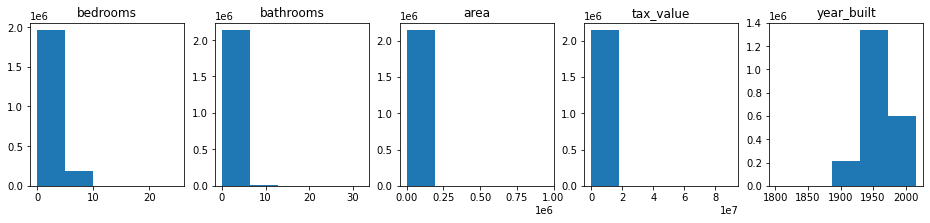

In [24]:
plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
plt.show()

In [25]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [26]:
df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'area', 'tax_value', 'taxamount'])
df

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
18,3.0,1.0,1244.0,169471.0,1950.0,2532.88,6037.0
19,3.0,2.0,1300.0,233266.0,1950.0,3110.99,6037.0
20,3.0,2.0,1222.0,290492.0,1951.0,3870.25,6037.0
...,...,...,...,...,...,...,...
2152853,3.0,2.0,1917.0,408680.0,1946.0,4341.32,6111.0
2152854,4.0,2.0,1987.0,259913.0,1955.0,3175.66,6059.0
2152856,3.0,2.5,1809.0,405547.0,2012.0,4181.10,6059.0
2152862,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


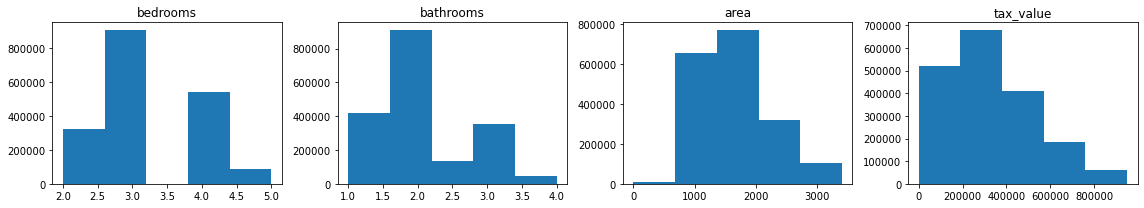

In [39]:
def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = ['bedrooms', 'bathrooms', 'area', 'tax_value']

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()
get_hist(df)

In [29]:
#get datatype for every column to decide what to change
cols = df.columns

for col in cols:
    
    print(col)
    print(df[col].value_counts())
    print()

bedrooms
3.0    904826
4.0    539616
2.0    320442
5.0     89402
Name: bedrooms, dtype: int64

bathrooms
2.00    909424
1.00    385677
3.00    351864
2.50    132322
4.00     31936
1.50     30713
3.50     12347
1.75         3
Name: bathrooms, dtype: int64

area
1200.0    5091
1080.0    4313
1120.0    4286
1400.0    3776
1440.0    3617
          ... 
390.0        1
296.0        1
389.0        1
380.0        1
462.0        1
Name: area, Length: 3013, dtype: int64

tax_value
450000.0    806
500000.0    753
400000.0    701
430000.0    677
440000.0    671
           ... 
173116.0      1
535870.0      1
64054.0       1
778669.0      1
366635.0      1
Name: tax_value, Length: 457377, dtype: int64

year_built
1955.0    80451
1950.0    66875
1954.0    65522
1953.0    58745
1956.0    58053
          ...  
1855.0        1
1874.0        1
1807.0        1
1833.0        1
1823.0        1
Name: year_built, Length: 152, dtype: int64

taxamount
345.72     164
344.18      71
343.52      65
49.18       45

In [ ]:
#changing the datatype for year because it will always be a whole number
df.year_built = df.year_built.astype(object)

In [36]:
def prepare_zillow(df):
    ''' Prepare zillow data for exploration'''

    # removing outliers
    df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'area', 'tax_value', 'taxamount'])
    
    # get distributions of numeric data
    get_hist(df)
    
    # converting column datatypes
    df.fips = df.fips.astype(object)
    df.year_built = df.year_built.astype(object)
    
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # impute year built using mode
    imputer = SimpleImputer(strategy='most_frequent')

    imputer.fit(train[['year_built']])

    train[['year_built']] = imputer.transform(train[['year_built']])
    validate[['year_built']] = imputer.transform(validate[['year_built']])
    test[['year_built']] = imputer.transform(test[['year_built']])       
    
    return train, validate, test 

In [37]:
def wrangle_zillow():
    '''Acquire and prepare data from Zillow database for explore'''
    train, validate, test = prepare_zillow(acquire_zillow())
    
    return train, validate, test 

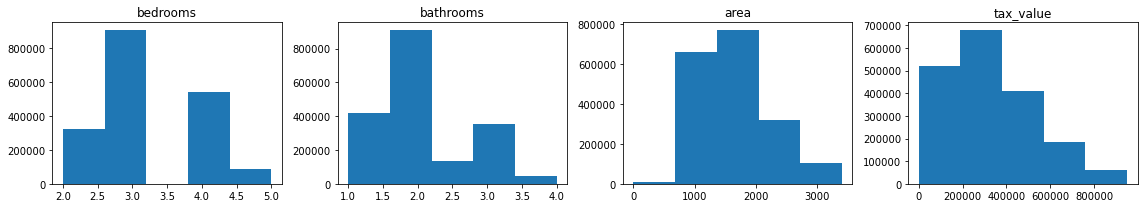

In [40]:
train, validate, test = wrangle_zillow()

### 3. Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe with no missing values in your `wrangle.py` file. Name your final function `wrangle_zillow`.